In [1153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [1154]:
df = pd.read_csv('/Users/alikhansainov/Desktop/Karpov/sigma_cabs.csv')
df.shape

(131662, 14)

In [1155]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [1156]:
df['Surge_Pricing_Type'].value_counts()

Surge_Pricing_Type
2    56728
3    47720
1    27214
Name: count, dtype: int64

Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [1157]:
### Your code is here

numeric_columns = df.select_dtypes(exclude=['object']).columns
categorical_columns = df.select_dtypes(include=['object']).columns


median = df[numeric_columns].median()
df[numeric_columns] = df[numeric_columns].fillna(median)

for col in categorical_columns:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)

for col in categorical_columns:
    ohe = pd.get_dummies(df[col], drop_first=True, dtype = float)
    df = pd.concat((df.drop(col, axis=1), ohe), axis=1)

correlation_matrix = df[numeric_columns].corr()
corr_pairs = correlation_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(ascending=False, key=abs)
sorted_pairs = sorted_pairs[sorted_pairs < 1]
sorted_pairs.head(5)


Var2              Var3                0.683437
Var3              Var2                0.683437
Trip_Distance     Life_Style_Index    0.468332
Life_Style_Index  Trip_Distance       0.468332
Var3              Life_Style_Index    0.303324
dtype: float64

### Training

In [1158]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

X

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,B,C,...,F,G,H,I,J,K,L,M,N,Male
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005908509,11.72,1.0,2.74229,3.28500,0,61.0,47,76,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
T0005908510,74.81,7.0,2.81059,0.44500,0,61.0,63,88,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
T0005908512,40.17,10.0,2.99565,3.33625,0,61.0,48,75,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1159]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [1160]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

### Your code is here
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

pipe = Pipeline([
    ('StandardScaler',StandardScaler()),
    ('one_vs_all', OneVsRestClassifier(estimator=LogisticRegression()))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
classreport = classification_report(y_test, y_pred, digits =3)
print (classreport)


              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [1161]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [1162]:
### Your code is here
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
search = GridSearchCV(pipe, param_grid, cv=None)
search.fit(X_train,y_train)
y_pred_grid = search.predict(X_test)
# scores = cross_val_score(pipe,X_train, y_train,cv=None )
print (search.best_params_) # C-0.01, penalty = l2
recallscore = recall_score(y_test, y_pred_grid, average=None)
print (recallscore[0])

{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}
0.533879374534624


Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

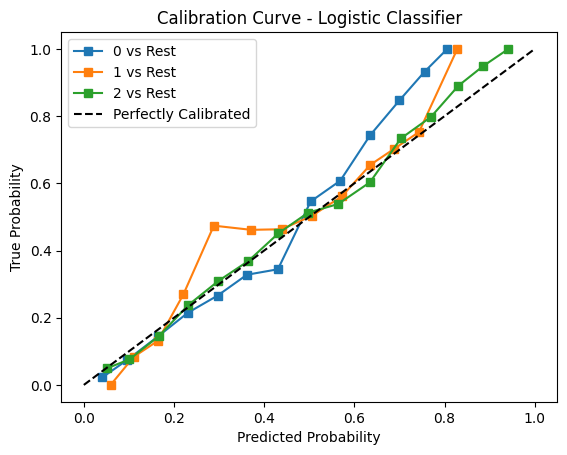

In [1165]:
### Your code is here
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1))

# Калибровочные кривые
for label in range(3):
    prob_pos = search.predict_proba(X_test)[:, label]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_ohe[:, label].toarray().ravel(),
                                                                    prob_pos,
                                                                    n_bins=15)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{label} vs Rest")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')

# Set plot labels and legend
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve - Logistic Classifier')
plt.legend()

plt.show()


**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [ ]:
### Создание полиномиальных признаков

X_polinomial = X.copy()
### Your code is here
num_cols = ['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3']

for col in num_cols:
    for power in [2, 3, 4]:
        to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)



Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type', 'B', 'C', 'D', 'E', 'B', 'C', 'B', 'C', 'D', 'E',
       'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Male'],
      dtype='object')

In [ ]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [ ]:
### Your code is here
pipe_pol = Pipeline([
    ('StandardScaler_pol', StandardScaler()),
    ('LogisticRegression_pol', OneVsRestClassifier(estimator=LogisticRegression(C=0.001, penalty='l2')))
])
# C-0.001, penalty = l2


pipe_pol.fit(X_pol_train, y_train)
y_pred_pol = pipe_pol.predict(X_pol_test)
print (classification_report(y_test, y_pred_pol, digits =3))


recall_pol = recall_score(y_test, y_pred_pol, average=None)
print (recall_pol[0])

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333

0.5323901712583767


По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

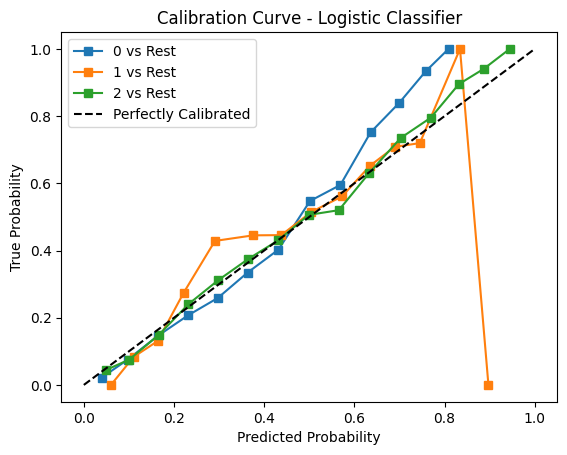

In [1168]:
### Your code is here
probs_pol = pipe_pol.predict_proba(X_pol_test)

# Plot the calibration curves for classes 1, 2, and 3
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1))

# Калибровочные кривые
for label in range(3):
    prob_pos = pipe_pol.predict_proba(X_pol_test)[:, label]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_ohe[:, label].toarray().ravel(),
                                                                    prob_pos,
                                                                    n_bins=15)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{label} vs Rest")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')

# Set plot labels and legend
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve - Logistic Classifier')
plt.legend()

plt.show()


**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here
SGDClassifier(loss='log')
pipeline = Pipeline([('scaler', StandardScaler()),('one_vs_all',OneVsOneClassifier(SGDClassifier()))])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
report = classification_report(y_test, y_pred, digits=3)
print (report)

              precision    recall  f1-score   support

           1      0.748     0.521     0.614      5372
           2      0.626     0.870     0.728     11349
           3      0.756     0.536     0.627      9612

    accuracy                          0.677     26333
   macro avg      0.710     0.642     0.656     26333
weighted avg      0.698     0.677     0.668     26333



In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [ ]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [ ]:
### Your code is here
from sklearn.model_selection import GridSearchCV
 
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])
search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=1)
search.fit(X_train, y_train)
print (search.best_params_)


y_pred = search.predict(X_test)
classreport = classification_report(y_test, y_pred, digits =3)
print (classreport)

# pipe_pol = Pipeline([
#     ('StandardScaler_pol', StandardScaler()),
#     ('LogisticRegression_pol', OneVsRestClassifier(estimator=LogisticRegression(C=0.001, penalty='l2')))
# ])

{'one_vs_one__estimator__alpha': 0.001, 'one_vs_one__estimator__loss': 'hinge', 'one_vs_one__estimator__penalty': 'l1'}
              precision    recall  f1-score   support

           1      0.743     0.527     0.617      5372
           2      0.625     0.876     0.730     11349
           3      0.767     0.527     0.625      9612

    accuracy                          0.678     26333
   macro avg      0.712     0.644     0.657     26333
weighted avg      0.701     0.678     0.668     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?